In [27]:
import os
import nibabel as nib
import numpy as np
import random
from tensorflow.keras.utils import to_categorical

In [28]:
image_dir = '/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_images2'
label_dir = '/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_labels2'

output_shape = (128,128,128)
class_num = 8

image_ids = [f.split('_')[2].split('.')[0] for f in os.listdir(image_dir)]
label_ids = [f.split('_')[2].split('.')[0] for f in os.listdir(label_dir)]


In [29]:
def get_image_data(image_paths):
    images = []
    for path in image_paths:
        image = nib.load(path)
        image_data = image.get_fdata()
        images.append(image_data)
    return images


def get_label_data(label_path):
    labels = []
    for path in label_path:
        label = nib.load(path)
        label_data = label.get_fdata()
        labels.append(label_data)
    return labels


def data_generator(image_paths, label_paths, batch_size):

    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_image_paths = image_paths[i:i+batch_size]
            batch_label_paths = label_paths[i:i+batch_size]

            batch_images = get_image_data(batch_image_paths)
            batch_labels = get_label_data(batch_label_paths)
                
            batch_images = np.array(batch_images)
            batch_labels = np.array(batch_labels)
            
            yield batch_images, batch_labels


In [30]:
image_ids = [f.split('_')[2].split('.')[0] for f in os.listdir(image_dir)]
label_ids = [f.split('_')[2].split('.')[0] for f in os.listdir(label_dir)]

np.random.seed(123)
num_epochs = 30
batch_size = 1
val_split = 0.3

for epoch in range(num_epochs):
    np.random.shuffle(image_ids)

    from sklearn.model_selection import train_test_split
    train_ids, val_ids = train_test_split(image_ids, test_size=0.3, random_state=123)

    train_image_paths = [os.path.join(image_dir, f'resized_image_{image_id}.nii') for image_id in train_ids]
    train_label_paths = [os.path.join(label_dir, f'resized_label_{image_id}.nii') for image_id in train_ids]
    val_image_paths = [os.path.join(image_dir, f'resized_image_{image_id}.nii') for image_id in val_ids]
    val_label_paths = [os.path.join(label_dir, f'resized_label_{image_id}.nii') for image_id in val_ids]

    train_steps = len(train_image_paths) // batch_size
    val_steps = len(val_image_paths) // batch_size

    train_generator = data_generator(train_image_paths, train_label_paths, batch_size)
    val_generator = data_generator(val_image_paths, val_label_paths, batch_size)

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, Dropout, BatchNormalization, Cropping3D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3DTranspose

In [81]:
def unet(input_size=(128, 128, 128, 1, 2), binary_model = False):
    inputs = Input((input_size[0], input_size[1], input_size[2], input_size[3]))

    # Downsample path
    conv1 = Conv3D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv3D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(256, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.3)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)

    # Bottleneck
    conv5 = Conv3D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv3D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.3)(conv5)

    #Decoder
    up6 = Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(drop5)
    merge6 = Concatenate(axis=4)([up6, drop4])
    conv6 = Conv3D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv3D(256, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv3DTranspose(128, 2, strides=(2, 2, 2), activation='relu', padding='same')(conv6)
    merge7 = Concatenate(axis=4)([conv3, up7])
    conv7 = Conv3D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv3D(128, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv3DTranspose(64, 2, strides=(2, 2, 2), activation='relu', padding='same')(UpSampling3D(size=(1, 1, 1))(conv7))
    merge8 = Concatenate(axis=4)([conv2, up8])
    conv8 = Conv3D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv3D(64, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv3DTranspose(32, 2, activation='relu', padding='same')(UpSampling3D(size=(2, 2, 2))(conv8))
    merge9 = Concatenate(axis=4)([conv1, up9])
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    if binary_model:
        outputs = Conv3D(1, (1, 1, 1), activation="sigmoid")(conv9)
    else:
      outputs = Conv3D(8, (1, 1, 1), activation="softmax")(conv9)

    model = Model(inputs, outputs)
    return model

In [69]:
from sklearn.metrics import f1_score

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()

        return 2.0 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [82]:
batch_size = 1
train_steps = len(train_image_paths) // batch_size
val_steps = len(val_image_paths) // batch_size

train_data = data_generator(train_image_paths, train_label_paths, batch_size)
val_data = data_generator(val_image_paths, val_label_paths, batch_size)

input_shape = (128, 128, 128, 1)

model = unet(input_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.MeanIoU(num_classes=2),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       F1Score()])

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_171 (Conv3D)             (None, 128, 128, 128 896         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_162 (BatchN (None, 128, 128, 128 128         conv3d_171[0][0]                 
__________________________________________________________________________________________________
conv3d_172 (Conv3D)             (None, 128, 128, 128 27680       batch_normalization_162[0][0]    
____________________________________________________________________________________________

In [47]:

for X, y in train_data:
    print("Train data shape:", X.shape)
    print("Train labels shape:", y.shape)
    break  

for X, y in val_data:
    print("Validation data shape:", X.shape)
    print("Validation labels shape:", y.shape)
    break  

print("Expected input shape of the model:", model.output_shape)

Train data shape: (1, 128, 128, 128, 1)
Train labels shape: (1, 128, 128, 128, 8)
Validation data shape: (1, 128, 128, 128, 1)
Validation labels shape: (1, 128, 128, 128, 8)
Expected input shape of the model: (None, 128, 128, 128, 8)


In [48]:
import tensorflow.keras.backend as K

def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def jaccard_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    jaccard = K.mean((intersection + smooth)/(union + smooth), axis=0)
    return jaccard


In [49]:
def evaluate(model, val_dataset):
    total_dice = 0
    total_jaccard = 0
    num_batches = 0
    for batch in val_dataset:
        x, y_true = batch
        x = tf.cast(x, tf.float64)
        y_true = tf.cast(y_true, tf.float64)
        y_pred = model.predict(x)
        y_pred = tf.cast(y_pred, tf.float64)
        dice = dice_coeff(y_true, y_pred)
        jaccard = jaccard_coeff(y_true, y_pred)
        total_dice += dice
        total_jaccard += jaccard
        num_batches += 1
    avg_dice = total_dice / num_batches
    avg_jaccard = total_jaccard / num_batches
    return {'dice_coefficient': avg_dice, 'jaccard_index': avg_jaccard}


In [83]:
history = model.fit(
    train_data,
    steps_per_epoch=train_steps,
    epochs=30,
    validation_data=val_data,
    validation_steps=val_steps
)


Epoch 1/30
12/12 [==============================] - 20s 1s/step - loss: 2.2406 - categorical_accuracy: 0.4089 - mean_io_u_8: 0.4375 - precision_6: 0.2071 - recall_6: 0.0149 - f1_score: 0.0275 - val_loss: 25235.0566 - val_categorical_accuracy: 0.0041 - val_mean_io_u_8: 0.3765 - val_precision_6: 0.0041 - val_recall_6: 0.0041 - val_f1_score: 0.0041
Epoch 2/30
12/12 [==============================] - 13s 1s/step - loss: 1.7372 - categorical_accuracy: 0.8242 - mean_io_u_8: 0.4375 - precision_6: 0.3821 - recall_6: 0.0047 - f1_score: 0.0093 - val_loss: 814647.5625 - val_categorical_accuracy: 0.0037 - val_mean_io_u_8: 0.3776 - val_precision_6: 0.0037 - val_recall_6: 0.0037 - val_f1_score: 0.0037
Epoch 3/30
12/12 [==============================] - 13s 1s/step - loss: 1.5701 - categorical_accuracy: 0.9289 - mean_io_u_8: 0.4375 - precision_6: 0.5759 - recall_6: 0.0034 - f1_score: 0.0068 - val_loss: 234169.7969 - val_categorical_accuracy: 0.0045 - val_mean_io_u_8: 0.3778 - val_precision_6: 0.0045 

In [84]:
model.save('/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/128_model_iou_f1.h5')

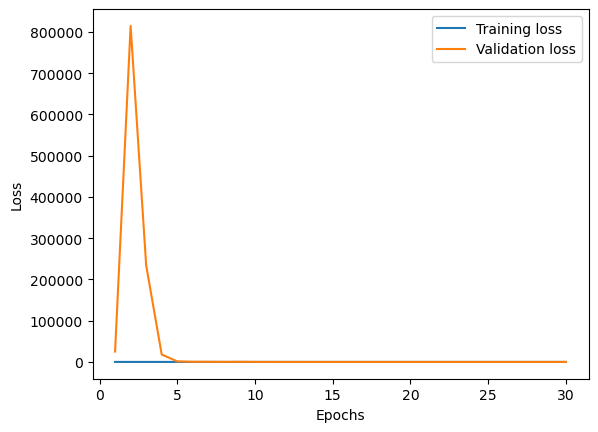

In [85]:
import matplotlib.pyplot as plt

train_losses = history.history['loss']
val_losses = history.history['val_loss']
num_epochs = range(1, len(train_losses) + 1)  

plt.plot(num_epochs, train_losses, label='Training loss')
plt.plot(num_epochs, val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

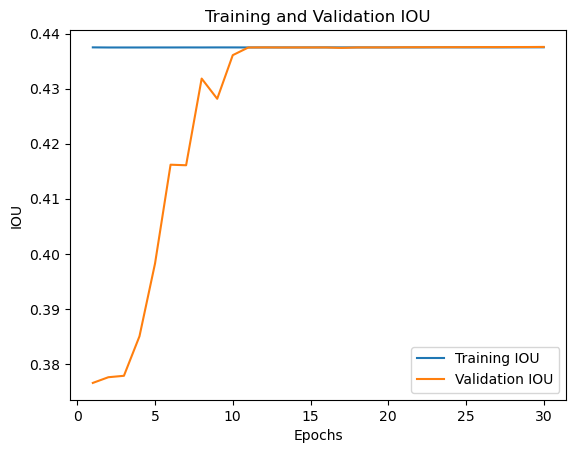

In [87]:
train_iou = history.history['mean_io_u_8']
val_iou = history.history['val_mean_io_u_8']
num_epochs = range(1, len(train_iou) + 1)  

plt.plot(num_epochs, train_iou, label='Training IOU')
plt.plot(num_epochs, val_iou, label='Validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.title('Training and Validation IOU')
plt.legend()
plt.show()


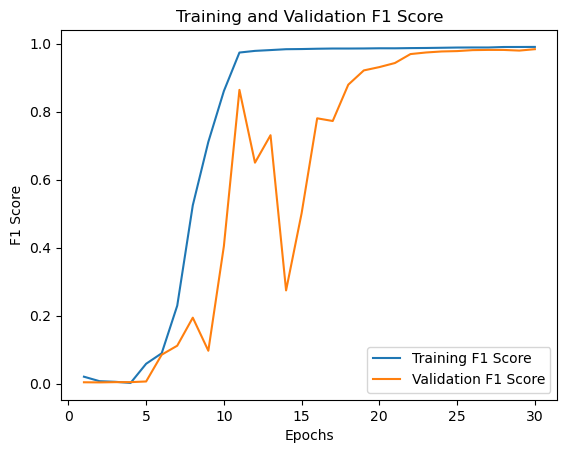

In [88]:
train_f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']
num_epochs = range(1, len(train_f1) + 1)  

plt.plot(num_epochs, train_f1, label='Training F1 Score')
plt.plot(num_epochs, val_f1, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()
plt.show()

In [ ]:
import scipy.ndimage

test_image = '/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_image_1019.nii'
test_image = nib.load(test_image).get_fdata()
resized_test_image = np.expand_dims(resized_test_image, axis=0)


predicted_mask = model.predict(resized_test_image)


In [179]:
predicted_mask = predicted_mask.astype(np.float64)


In [180]:
ground_truth_mask = '/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_label_1019.nii'
ground_truth_mask = nib.load(ground_truth_mask).get_fdata()


dice = 2 * np.sum(predicted_mask * ground_truth_mask) / (np.sum(predicted_mask) + np.sum(ground_truth_mask))
intersection = np.sum(predicted_mask * ground_truth_mask)
union = np.sum(predicted_mask) + np.sum(ground_truth_mask) - intersection
jaccard = intersection / union

print("Dice coefficient:", dice)
print("Jaccard similarity:", jaccard)


Dice coefficient: 0.9454115724618063
Jaccard similarity: 0.8964744423269965


In [96]:
print(predicted_mask.shape)

(1, 128, 128, 128, 8)


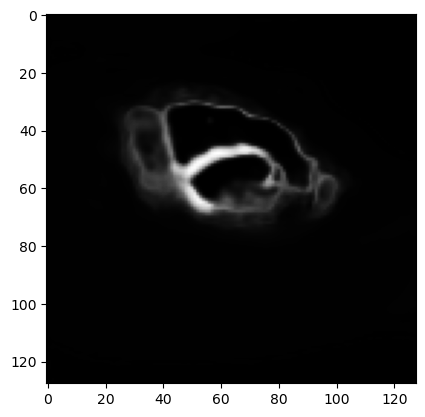

In [149]:
# Select the first channel of the predicted mask
channel = 1
slice_2d = predicted_mask[0, :, :, int(predicted_mask.shape[3] / 2), channel]

# Display the 2D slice
plt.imshow(slice_2d, cmap='gray')


In [105]:
print(ground_truth_mask.shape)

(128, 128, 128, 8)


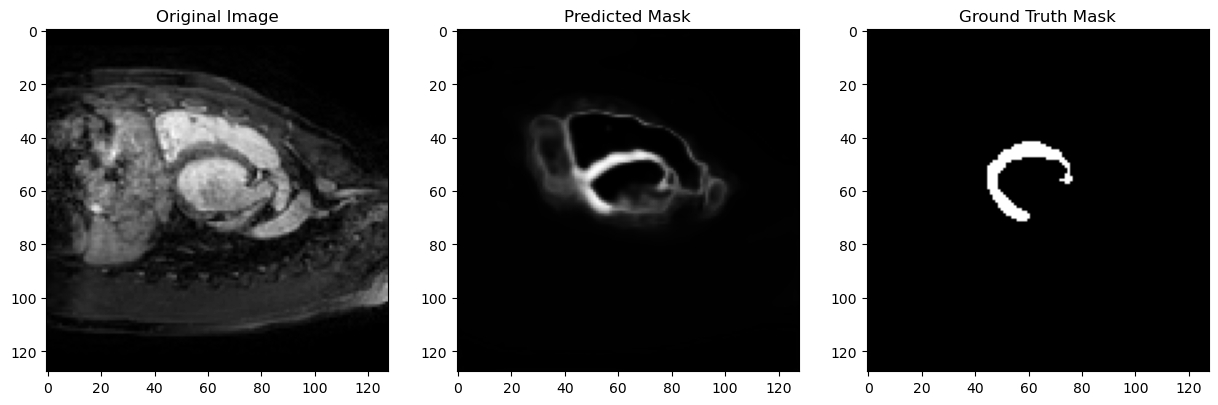

In [153]:
channel = 1
ground_truth_2d = ground_truth_mask[:, :, 60, channel]

f, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(test_image[:, :, 60], cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(slice_2d, cmap='gray')
ax[1].set_title('Predicted Mask')
ax[2].imshow(ground_truth_2d, cmap='gray')
ax[2].set_title('Ground Truth Mask')

plt.show()


In [139]:
test_image2 = '/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_image_1020.nii'
test_image2 = nib.load(test_image2).get_fdata()
print(test_image2.shape)
resized_test_image2 = np.expand_dims(test_image2, axis=0)

predicted_mask2 = model.predict(resized_test_image2)

(128, 128, 128, 1)


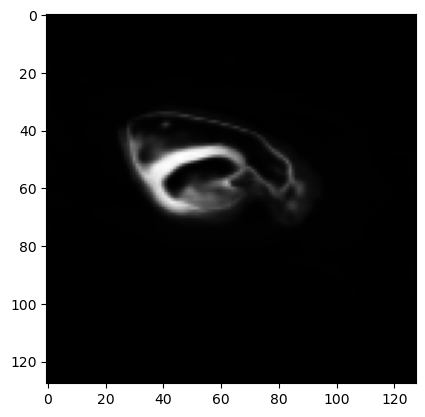

In [171]:
channel = 1
slice2_2d = predicted_mask2[0, :, :, 65, channel]

# Display the 2D slice
plt.imshow(slice2_2d, cmap='gray')


In [143]:
ground_truth_mask2 = '/home/teakrcmar/Desktop/3D_Unet_HeartSegmentation/mr_train/resized_label_1020.nii'
ground_truth_mask2 = nib.load(ground_truth_mask2).get_fdata()


dice = 2 * np.sum(predicted_mask2 * ground_truth_mask2) / (np.sum(predicted_mask2) + np.sum(ground_truth_mask2))

intersection = np.sum(predicted_mask2 * ground_truth_mask2)
union = np.sum(predicted_mask2) + np.sum(ground_truth_mask2) - intersection
jaccard = intersection / union

print("Dice coefficient:", dice)
print("Jaccard similarity:", jaccard)


Dice coefficient: 0.9528979182747002
Jaccard similarity: 0.9100334484147139


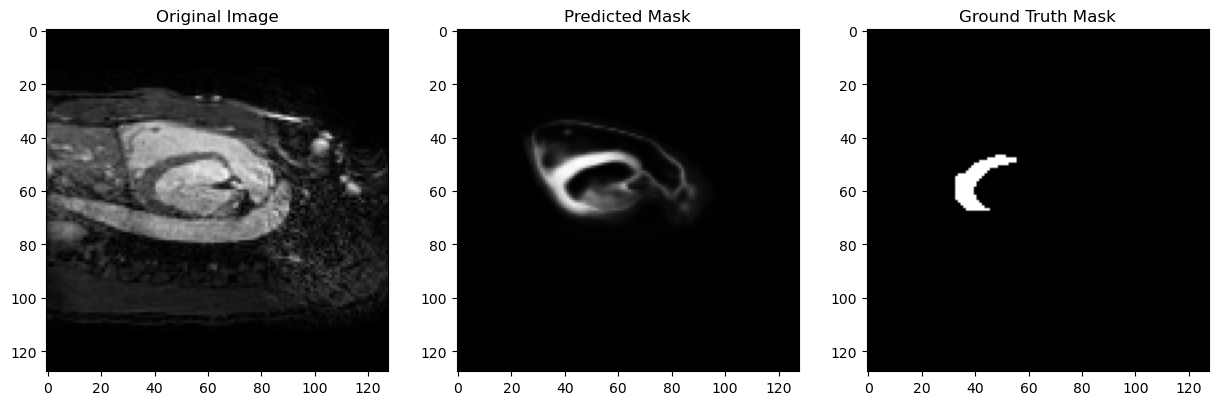

In [172]:
channel = 1
ground_truth2_2d = ground_truth_mask2[:, :, 65, channel]

f, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(test_image2[:, :, 65], cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(slice2_2d, cmap='gray')
ax[1].set_title('Predicted Mask')
ax[2].imshow(ground_truth2_2d, cmap='gray')
ax[2].set_title('Ground Truth Mask')

plt.show()


In [182]:
class_labels = [500, 600, 420, 550, 205, 820, 850]
precision = {}

for label in class_labels:
    precision[label] = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0, 'precision': 0.0}

# Iterate over the predicted and ground truth masks
for pred_pixel, gt_pixel in zip(predicted_mask.flatten(), ground_truth_mask.flatten()):
    pred_label = int(pred_pixel)
    gt_label = int(gt_pixel)

    if pred_label in class_labels:
        if pred_label == gt_label:
            precision[pred_label]['TP'] += 1
        else:
            precision[pred_label]['FP'] += 1
            precision[gt_label]['FN'] += 1
        for label in class_labels:
            if label != pred_label and label != gt_label:
                precision[label]['TN'] += 1

# Calculate precision for each class
for label in class_labels:
    tp = precision[label]['TP']
    fp = precision[label]['FP']
    
    if tp + fp > 0:
        precision[label]['precision'] = tp / (tp + fp)

# Print precision values for each class
for label, values in precision.items():
    print(f"Label {label}: Precision = {values['precision']}")


Label 500: Precision = 0.0
Label 600: Precision = 0.0
Label 420: Precision = 0.0
Label 550: Precision = 0.0
Label 205: Precision = 0.0
Label 820: Precision = 0.0
Label 850: Precision = 0.0
